<h1> Pipelines </h1>
Sachin Soman 
<h3> Background Information on data used for part 1</h3>

#### Haberman's Survival Data Set
The dataset was dervived from the study conducted by University of Chicago Billings hospital.The data is on the survival of patients who had undergone breast cancer surgery collected from 1958 to 1970

|     Charactrestics    |          Data         |
|:---------------------:|:---------------------:|
| Data Set              |      Multivariate     |
| Attribute:            |        Integer        |
| Number of Instances:  |          306          |
| Number of Attributes: |           3           |
| Missing Values?       |           No          |
| Assoicated Task       |       Pipeline        |
    
### Attribute Information:

1. Age of patient at time of operation (numerical) 
2. Patient's year of operation (year - 1900, numerical) 
3. Number of positive axillary nodes detected (numerical) 
4. Survival status (class attribute)
    <ul>
        <li>1 = the patient survived 5 years or longer </li>
        <li>2 = the patient died within 5 year </li> </ul>

## Objective

<p>In our first assignment we worked on a highly biased dataset and tried to remove the effect of data imbalance on the trained model. We tried a number of strategies with varying degree of success. We also found out that both holdout and cross validation will give different results owing to small size of data making the results unstable. </p>





<blockquote>
    Task:1
    <br>
    <p>
In this section we will try to repeat the process however we will do it with help of pipelines and compare it with a baseline generated from a holdout evaluvation.
</p>
</blockquote>

For this task we will first see the perfomance of <b> gradient boost </b> 

<h2>Part 1 Exploratory Analysis</h2>
    <p>Objective</p>
    <ol><li>Import all required libraries</li>
    <li>Find initial dimension of data</li>
        <li>Convert the features to their appropriate data types </li>
        <li>See if the data is skewed or not</li>
    
    
    

<h3>1.Import libraries</h3>
<p> The most important library used is the <b>pandas</b>, this enables the csv to be converted to a pandas datatype and allow data manipulation. <b>Numpy</b> library adds array like functionalities to python for scientific calculations. The visulaization is carried out using <b>Matplotlib</b> and <b>Seaborn</b>. The Counter data structure from collections is used to obtain the count of unique objects in a more efficent manner. Some libraries are not added here as having them imported later with initialization will be easier for readability

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score

from sklearn.ensemble import GradientBoostingClassifier


from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score


from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict

import random
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels

In [2]:
# Eliminate all warnings
import warnings
warnings.simplefilter('ignore')

In [3]:
df = pd.read_csv('survival.csv')
plot = df

Peek into the dataframe to get a general sense of what the data looks like. Since we already know from the UCI repository that the data is clea we need not do any imputations or major pre-processing

In [4]:
df.head()

,Age,Year,NNodes,Class
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


The <b>class</b> attribute shows wherther a patient lived less than 5 years or more than 5 years after surgery. This feature will be expanded upon to make it more interpretable

In [5]:
df['Survived'] = 'GE5'
df.loc[df['Class']==2,'Survived']='L5'
df.head()

,Age,Year,NNodes,Class,Survived
0,30,64,1,1,GE5
1,30,62,3,1,GE5
2,30,65,0,1,GE5
3,31,59,2,1,GE5
4,31,65,4,1,GE5


Lets look at the how well the target data is distributed

GE5    225
L5      81
Name: Survived, dtype: int64


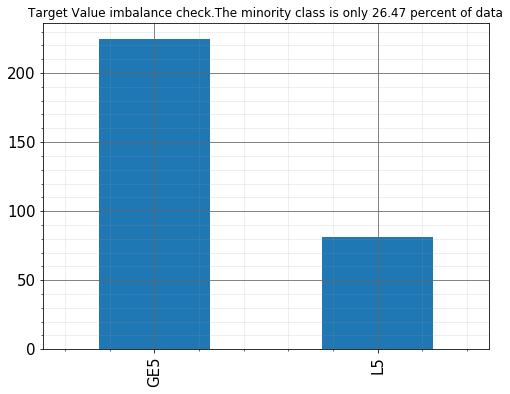

In [6]:
print(df['Survived'].value_counts())
df['Survived'].value_counts().plot(kind='bar', figsize=(8,6),title="Target Value imbalance check.The minority class is only %0.2f percent of data"%(Counter(df["Survived"])["L5"]/len(df)*100),fontsize=15)
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)


Looking at the count for the two classes we can see that the classes are imbalanced
<blockquote>Observations</blockquote>
<ul>
<li>81 data points classified as L5.</li>
<li>225 data points classfifed as GE5</li>
<li>Minority class only makes 26 percent of the data</li>
</ul>


<h3> Prepration of data for training and evaluvation</h3>
In order for training to done we now have to split the dataframe into input and target

In [7]:
# o,1 mapping for easier implimentation where positive class will be majority
df.loc[df['Survived'] == 'GE5', 'Survived'] = 1
df.loc[df['Survived'] == 'L5', 'Survived'] = 0


# Seperating to target value
y = df.pop('Survived').values
# Class attribute is now redundant therefore removing it
df.pop('Class')
# Training input dataframe
X = df.values
y=y.astype('int')

These are some dictionaries which will store results and gets converted to dataframes later

In [8]:
f1_scores = {'hold_out': [],
        'f1': [],
             'hue_factor':[]
        }

# f1_scores_cv = {'hold_out': [],
#         'f1': [],
#              'hue_factor':[]
#         }


holdout = {'hold_out': [],
            'hold_out_accuracy': [],
            'hold_out_recall':[],
          
              
            'cv_test_accuracy':[],
            'cv_predicted_recall':[],
           
             }

Visualizing the data to see how the data is distributed. We can get a better understanding if we project the 3D data onto a plane like by using PCA

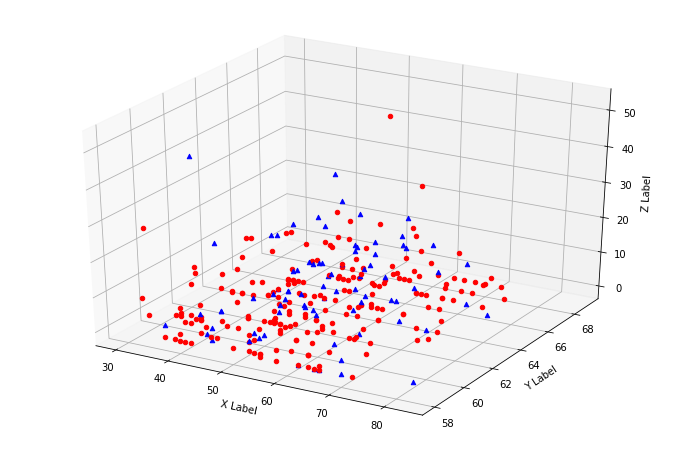

In [9]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

data = pd.read_csv("Survival.csv")

fig = plt.figure(figsize = (12, 8))

ax = fig.add_subplot(111, projection='3d')
axis = 0
for x in range(len(data)):
    if(data["Class"][x] == 1):
        ax.scatter(data["Age"][x], data["Year"][x], data["NNodes"][x],marker='o',c='r')
    else:
        ax.scatter(data["Age"][x], data["Year"][x], data["NNodes"][x],marker='^',c='b')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()



# Part 1

## Objective

<p> In this section since we have done the data prepration and some EDA, We will go about training the models and see how they perform. Remember we are looking to see how unstable the perfomance of a classifer is when we use holdout. For this we will just use <b> gradient boost </b> with multiple split size and see how the results vary and keep it as a baseline for us to compare with <b>pipeline</b> and <b>cross-validation</b> </p>


### Metrics used for Experiment - Bias

The first hypothesis we have is that the models trained on the dataset are going to be highly biased towards the majority class. To see if this hypothesis is true or not we can check for the number of measures. The most obvious one is to measure the percentage of the minority class in the test set vs the predicted minority class. If the prediction value is low it means the model is not predicting enough negative classes, However, This metric has some flaws. It doesn't tell if the model prediction of negative classes is a true negative or not. Therefore to see the bias in our model and to see how the model is performing we will use <b>F1-score</b>and <b> Recall </b>
<br><br>
The best way to explain recall is with an example. Let's say we have 100 patients and 20 patients have cancer. If our model detects 20 patents to have cancer and they are true positives it means that we have a recall of 1. So recall in our case will be the ratio of the number of target values detected which is correct to the total number of target values in our test. Thus a low recall means we are not detecting enough of that particular class. For sake of simplicity, I will use F1 score for the plot as a lower F1 score also indicates a poor recall. 

### Checking stability

#### Method - 1
Though as proposed above, the measures will indicate the bias. Our current analysis will focus on stability of the model. We will see how accuracy is varying when we train the gradient boost model with <b> different holdout. We will do a better one later

In [10]:
test_sz = [.4,.45,.5,.55,.6,.65,.7,.75,.8]

# Gradient Boosting

In [11]:
gboost = GradientBoostingClassifier(random_state=0)
# testing with different test size
for x in test_sz:
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = x, random_state=42)
    y_pred = gboost.fit(X_train, y_train).predict(X_test)

    print(f'Accuracy of  GradientBoostingClassifier is at:  {accuracy_score(y_pred, y_test)*100:.2f}% ')

    pred_neg = Counter(y_pred)[0]
    test_neg = Counter(y_test)[0]

    print("Minority class in test set : %0.2f" % (test_neg/len(y_test)))
    print("Predicted minority class : %0.2f" % (pred_neg/len(y_pred)))


    holdout["hold_out"].append("Hold_out_"+str(x))
    holdout["hold_out_accuracy"].append(accuracy_score(y_pred, y_test))
    holdout["hold_out_recall"].append((recall_score(y_test, y_pred, pos_label=0)))
    report = classification_report(y_test, y_pred)
    f1_scores["hold_out"].append("Hold_out_"+str(x))
    f1_scores["f1"].append(f1_score(y_test, y_pred, pos_label=1))
    f1_scores["hue_factor"].append(1)
    # --------0-------
    f1_scores["hold_out"].append("Hold_out_"+str(x))
    f1_scores["f1"].append(f1_score(y_test, y_pred, pos_label=0))
    f1_scores["hue_factor"].append(0)
    


Accuracy of  GradientBoostingClassifier is at:  72.36% 
Minority class in test set : 0.27
Predicted minority class : 0.17
Accuracy of  GradientBoostingClassifier is at:  71.01% 
Minority class in test set : 0.25
Predicted minority class : 0.17
Accuracy of  GradientBoostingClassifier is at:  69.93% 
Minority class in test set : 0.24
Predicted minority class : 0.24
Accuracy of  GradientBoostingClassifier is at:  67.46% 
Minority class in test set : 0.24
Predicted minority class : 0.24
Accuracy of  GradientBoostingClassifier is at:  65.76% 
Minority class in test set : 0.26
Predicted minority class : 0.22
Accuracy of  GradientBoostingClassifier is at:  69.85% 
Minority class in test set : 0.26
Predicted minority class : 0.20
Accuracy of  GradientBoostingClassifier is at:  69.30% 
Minority class in test set : 0.26
Predicted minority class : 0.24
Accuracy of  GradientBoostingClassifier is at:  67.83% 
Minority class in test set : 0.27
Predicted minority class : 0.20
Accuracy of  GradientBoo

In [12]:
f1_scores = pd.DataFrame(f1_scores, columns = ['models', 'f1','hue_factor'])

Text(0, 0.5, 'Accuracy')

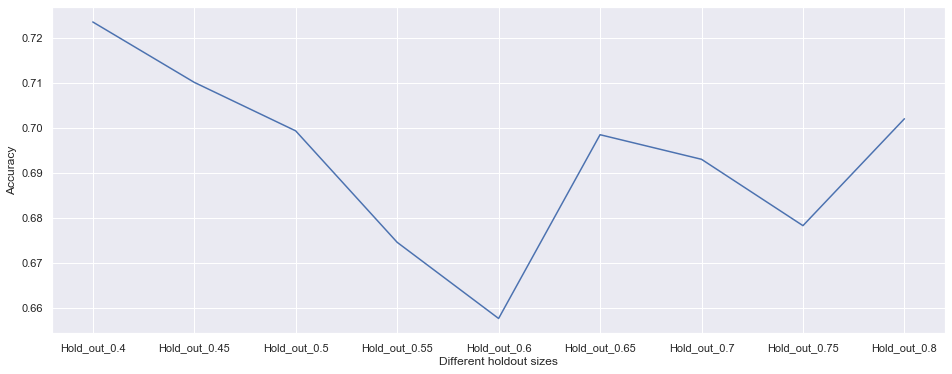

In [13]:
sns.set_theme()
plt.figure(figsize=(16, 6))
sns.lineplot(data=holdout, x=holdout["hold_out"], y=holdout["hold_out_accuracy"])
plt.xlabel("Different holdout sizes")
plt.ylabel("Accuracy")

Plotting accuracy vs the different holdout sample gave us a good picture of how unstable the model is. The line plot is an ideal cadidate to show the fluctuations. Now that we know that the model is unstable. We will repeat the same process with SMOTE and create a baseline to compare with cross validation and pipelines. So that we get a better understanding of the model and try to rectify the issue of bias. 

### Checking stability

#### Method - 2
there is a more compelling way to test unstability we have set different test-train split by giving random_state for test_train_split with that we can train the model and see the accuracy. This should give us a better picture

In [14]:
result={
    'test':[],
    'accuracy':[]
    
}

for x in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .5, random_state=random.randint(10,10000))
    gboost = GradientBoostingClassifier(random_state=0)
    result['test'].append(x)
    y_pred = gboost.fit(X_train, y_train).predict(X_test)
    result["accuracy"].append(accuracy_score(y_pred, y_test)) 

Text(0, 0.5, 'Accuracy')

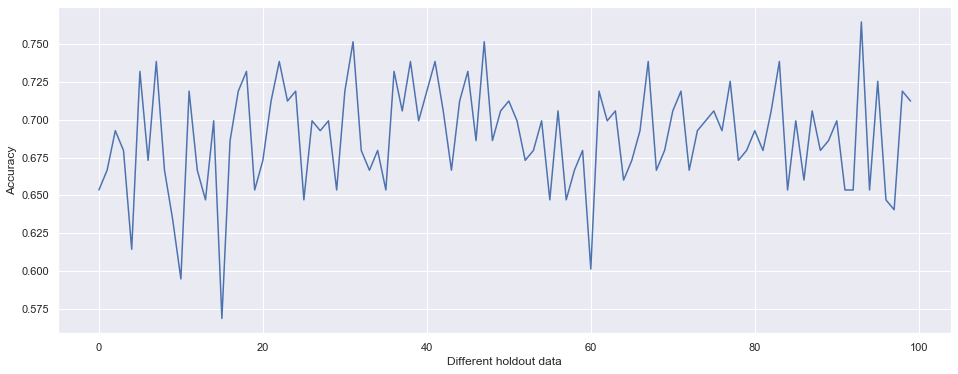

In [15]:
sns.set_theme()
plt.figure(figsize=(16, 6))
sns.lineplot(data=result, x=result["test"], y=result["accuracy"])
plt.xlabel("Different holdout data")
plt.ylabel("Accuracy")

# Observations 

We can from the above plots indeed see high levels of unstability when it comes to results from using hold-out test. We will do the same experiment but now we will employ SMOTE we expect to get same result however we want to reduce the effect of bias before we check out how stable the model is using hodlout

# SMOTE

SMOTE stands for Synthetic Minority Oversampling. The basic idea is that if there are two points belonging to same class in a dimension space then its safe to assume that there are data points inbetween that belong to same class. SMOTE uses this concept of nearest neighnours to artificaially create new data points.

In [16]:
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
# Separate input features and target
# y = df.Survived
# X = df.drop('Survived', axis=1)

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

sm = SMOTE(random_state=42, sampling_strategy=1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)

So We only do smote on training data Since we did a .5 split it means we are left with 153 data points(306/2). Initially we has 108 data points in majority and 45 data points in minority. After smote the number becomes 108 each

In [17]:
Counter(y_train)

Counter({1: 108, 0: 108})

In [18]:
result_smote=[]


for x in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=random.randint(10,10000))
    sm = SMOTE(random_state=42)
    X_train, y_train = sm.fit_sample(X_train, y_train)
    gboost = GradientBoostingClassifier(random_state=0)
    y_pred = gboost.fit(X_train, y_train).predict(X_test)
    result_smote.append(accuracy_score(y_pred, y_test)) 

Text(0, 0.5, 'Accuracy')

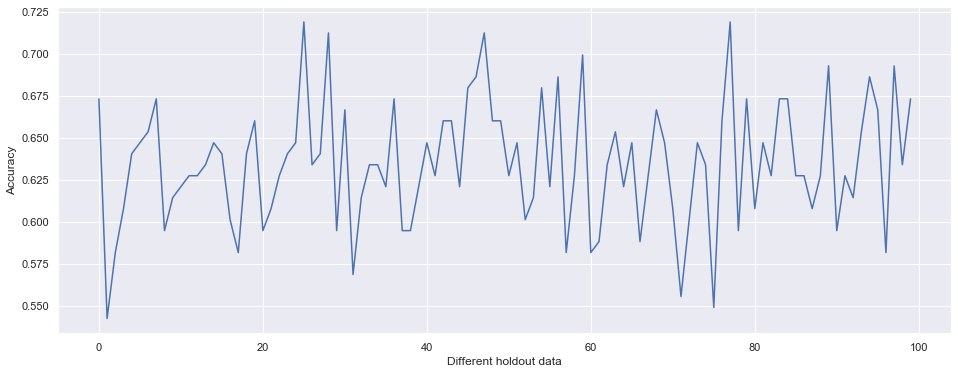

In [19]:
sns.set_theme()
plt.figure(figsize=(16, 6))
sns.lineplot(data=result_smote)
plt.xlabel("Different holdout data")
plt.ylabel("Accuracy")

Even with bias rectified a hold-out based sampling gives unstable accuracy



# pipelines


For pipelines we will we will introduce smote. Since smote is an oversampling technique the normal sklearn pipeline is not supported and we have to use the imblearn library for the purpose.

Like before we will do a 10 fold crossvalidation for total of 100 times with suffle enabled meaning we get different splits each time. After which we will compare same with holdout variation and see the stability of ech implimentation

In [20]:
result_cv=[]

from imblearn.pipeline import Pipeline, make_pipeline
for x in range(100):
    kf = KFold(n_splits=10, shuffle = True)
    imba_pipeline = make_pipeline(KNNImputer(missing_values = np.nan),
    StandardScaler(),SMOTE(random_state=42), 
                                  GradientBoostingClassifier(random_state=0))
    result = cross_val_score(imba_pipeline, X_train, y_train, scoring='accuracy', cv=kf)
    result=result.mean()
    result_cv.append(result)


In [21]:
df = pd.DataFrame(list(zip(result_smote, result_cv)), 
               columns =['holdout', 'pipeline_cv'])

Text(0, 0.5, 'Accuracy')

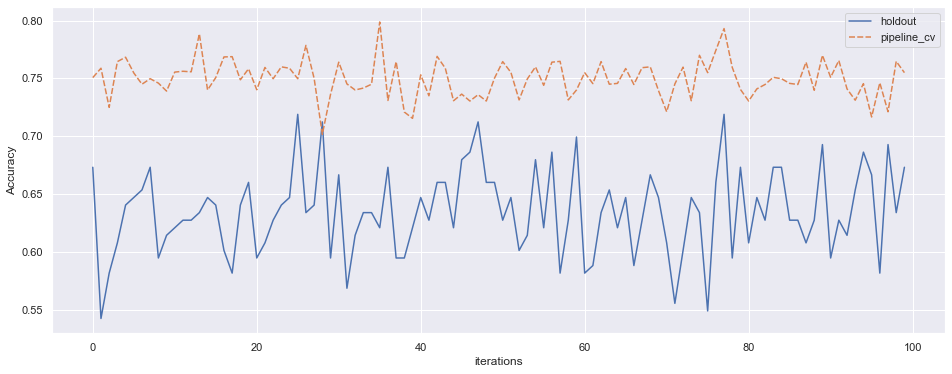

In [22]:
sns.set_theme()
plt.figure(figsize=(16, 6))
sns.lineplot(data=df )

plt.xlabel("iterations")
plt.ylabel("Accuracy")

# Observations 

The main reason for using plots is to allow the reader to get the full picture than forcing them to make an iterpretation. With that in mind, a line plot of both the observations is produced. We can make several observations

<blockquote>
    
    
    
        
- The variations in accuracy across iteration of holdout is much higher than that of pipelines.This shows that holdout is the more unstable of the the two
        
        
- The crossvalidated accuracy is shifted above holdout indicating we get better average when we use cross validation. This is because the model has more data to train on compared to holdout. Hence in our case cross validation is better     


    
   
    
    
</blockquote>

# Other Measures 
We had earlier stated why we will be using F1 score for bias checking. Before we conclude pipelines F1 measures of all the approches are complied and ploted


In [23]:
f1_scores = {'approach': [],
        'f1': [],
             'hue_factor':[]
        }

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .5, random_state=42)
gboost = GradientBoostingClassifier(random_state=0)
y_pred = gboost.fit(X_train, y_train).predict(X_test)

f1_scores["approach"].append("Holdout_no_smote")
f1_scores["f1"].append(f1_score(y_test, y_pred, pos_label=1))
f1_scores["hue_factor"].append(1)
# --------0-------
f1_scores["approach"].append("Holdout_no_smote")
f1_scores["f1"].append(f1_score(y_test, y_pred, pos_label=0))
f1_scores["hue_factor"].append(0)

In [25]:

sm = SMOTE(random_state=42, sampling_strategy=1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)
gboost = GradientBoostingClassifier(random_state=0)
y_pred = gboost.fit(X_train, y_train).predict(X_test)

f1_scores["approach"].append("Smote")
f1_scores["f1"].append(f1_score(y_test, y_pred, pos_label=1))
f1_scores["hue_factor"].append(1)
# --------0-------
f1_scores["approach"].append("Smote")
f1_scores["f1"].append(f1_score(y_test, y_pred, pos_label=0))
f1_scores["hue_factor"].append(0)

In [26]:


# KFold cross validation
cv = KFold(n_splits=25)
y_pred = cross_val_predict(GradientBoostingClassifier(random_state=0), X, y, cv = cv)

f1_scores["approach"].append("Smote-cross_validated")
f1_scores["f1"].append(f1_score(y, y_pred, pos_label=1))
f1_scores["hue_factor"].append(1)
#     --------0-------
f1_scores["approach"].append("Smote-cross_validated")
f1_scores["f1"].append(f1_score(y, y_pred, pos_label=0))
f1_scores["hue_factor"].append(0)



In [27]:
f1_scores = pd.DataFrame(f1_scores, columns = ['approach', 'f1','hue_factor'])

### Hypothesis
Our Hypothesis was that for the given dataset. All the models will be biased towards the majority class. We proposed to use F1 scores as stated earblier for evaluating the hypothesis. We will now use a grouped bar chart which will Plot the F1 Scores of each model as a pair of F1 scores for the majority and minority classes

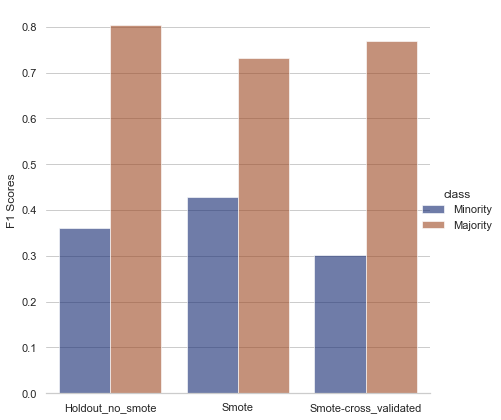

In [28]:
%matplotlib inline
import seaborn as sns
sns.set_theme(style="whitegrid")


# Draw a nested barplot by F1 scores
g = sns.catplot(
    data=f1_scores, kind="bar",
    x="approach", y="f1", hue="hue_factor",
    ci="sd", palette="dark", alpha=.6, height=6,legend_out = True
)
new_labels = ['Minority', 'Majority']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
g.despine(left=True)
g.set_axis_labels("", "F1 Scores")
g.legend.set_title("class")

From the compiled results . We can observe that for each model the F1 scores are extremely low for the minority class. This observation validates our hypothesis that the models are indeed <b> biased to the majority class</b> 

<br>
We see an improvement in F1 when we used Smote however when we did cross validation we see a dergradation in perfomance indicating that SMOTE may not be the best approch for the given model

# Part 2 - Model Selection

<h1> Model Selection </h1>

#### Heart Data Set
The dataset was provided for testing model selection

|     Charactrestics    |          Data         |
|:---------------------:|:---------------------:|
| Data Set              |      Multivariate     |
| Attribute:            |        Integer        |
| Number of Instances:  |          199          |
| Number of Attributes: |          13           |
| Missing Values?       |           No          |
| Assoicated Task       |Model Selection        |
    


First lets load up the data

In [29]:
df_train = pd.read_csv('heart-train.csv')

In [30]:
df_train.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,60.0,0,253,0,35,0,279000.00,1.70,140,1,0,250,0
1,40.0,1,129,0,35,0,255000.00,0.90,137,1,0,209,0
2,86.0,0,582,0,38,0,263358.03,1.83,134,0,0,95,1
3,45.0,0,582,0,35,0,385000.00,1.00,145,1,0,61,1
4,72.0,0,127,1,50,1,218000.00,1.00,134,1,0,33,0


First thing we notice is that different attributes are in different scales this means we need to normalize the features to train the model better, However in interest of analysis we will see how well the models get trained when we use 
- unscaled data
- Scaled data
- Normalized data

In [31]:
# Seperating to target value
y_t = df_train.pop('DEATH_EVENT').values
# Class attribute is now redundant therefore removing it
# Training input dataframe
X_t = df_train.values
y_t=y_t.astype('int')

We will do crossvalidation on train data to see the internal accuracy

In [32]:
gboost = GradientBoostingClassifier(random_state=0)
# KFold cross validation
cv = KFold(n_splits=10)
y_pred = cross_val_predict(gboost, X, y, cv = cv)
print("Crossvalidation score on train data")
print(f"Model: {type(gboost).__name__}")
print(f'Accuracy of GBoost is at:  {accuracy_score(y_pred, y)*100:.2f}% ')
print("--------------------------------")


Crossvalidation score on train data
Model: GradientBoostingClassifier
Accuracy of GBoost is at:  69.61% 
--------------------------------


prepare the test data from prediction Note We did not use test data for training

In [33]:
df_test = pd.read_csv('heart-test.csv')

In [34]:
# Seperating to target value
y_test = df_test.pop('DEATH_EVENT').values
# Class attribute is now redundant therefore removing it
# Training input dataframe
X_test = df_test.values
y_test=y_test.astype('int')

Training Gboost using train and testing using test data We get 82% accuracy

In [35]:
gboost = GradientBoostingClassifier(random_state=0)
y_pred = gboost.fit(X_t, y_t).predict(X_test)
baseline = classification_report(y_test, y_pred)
baseline_accuracy = accuracy_score(y_pred, y_test)*100
print(f'Accuracy of GBoost is at:  {accuracy_score(y_pred, y_test)*100:.2f}% ')

Accuracy of GBoost is at:  82.00% 


However, Accuracy does not give a full story so lets look at the full report

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87        68
           1       0.73      0.69      0.71        32

    accuracy                           0.82       100
   macro avg       0.80      0.78      0.79       100
weighted avg       0.82      0.82      0.82       100



### Observation
Interestingly the baseline model is giving decent results for our model with recall being low for class 1. Our objective here is to keep this as baseline and to see if we can achieve almost same results with reduced number of features. The reason for this is that sometimes having less features will provide significantly better train time which is a good trade off when dealing with large scale ML applications 

In [37]:
# Confusion Matrix plot
%matplotlib inline

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plt.show()

Confusion matrix, without normalization
[[60  8]
 [10 22]]


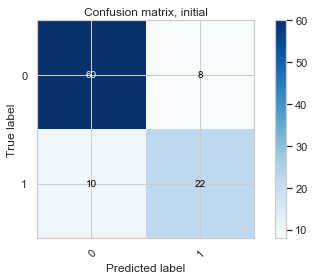

In [38]:
plot_confusion_matrix(y_test, y_pred, classes=[0,1],
                      title='Confusion matrix, initial')

## Objective 

To find out usefull features we will use 3 approches each trying to validate other observations. 
- We will first try using mutual information gain to see which features provide most information based on entropy calculations. We will do this for scaled,unscaled and normalised features. Basically its a score based on how each feature can explain the target 

#### Note
Looking at the documentation for <b> mutual_info_classifier</b> we see that this information gain is calculated using an internal dicision tree. Implying that we may get different results each time we do a test. Introducing some unstability to our analysis

- After that we will do a forward and backward feature selectiona and try to get an intersection of features. If the feature set we get matches the information gain score of the attibutes we can assume that only those features are required for training model

- we will finally do a training based on that model alone and see the score with baseline to verify the claim

In [39]:
import pandas as pd
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn import preprocessing
gboost = GradientBoostingClassifier(random_state=0)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [40]:
df_train = pd.read_csv('heart-train.csv')

In [41]:
print(df_train.shape)

(199, 13)


Helper information gain function

In [42]:
# Seperating to target value
y_t = df_train.pop('DEATH_EVENT').values
# Class attribute is now redundant therefore removing it
# Training input dataframe
X_t = df_train.values
y_t=y_t.astype('int')

Note this is where we get bit of unstability however this is minor hence we will ignore the small discrepancy 

In [43]:
def info_gain_analysis(X_t,y_t):
    i_scores = mutual_info_classif(X_t,y_t)
    FS_DF = pd.DataFrame(i_scores,index = df_train.columns, columns =['I-Gain'])
    FS_DF.sort_values(by=['I-Gain'],ascending=False,inplace=True)
    display(FS_DF)
    return FS_DF

#### Steps
Here we will do information gain analysis as stated earlierwe will do analysis on
- normalized data
- Scaled data
- Unprocessed data 

And see if there is any difference

In [44]:
unscaled_df_analysis = info_gain_analysis(X_t,y_t)

,I-Gain
time,0.218131
serum_creatinine,0.090043
ejection_fraction,0.080293
age,0.077693
diabetes,0.052433
smoking,0.042077
serum_sodium,0.015665
sex,0.006954
anaemia,0.000000
creatinine_phosphokinase,0.000000


In [45]:
normalized_df_analysis = info_gain_analysis(preprocessing.normalize(X_t),y_t)

,I-Gain
time,0.146406
serum_creatinine,0.104985
ejection_fraction,0.062078
platelets,0.059313
serum_sodium,0.022819
sex,0.021555
age,0.006775
creatinine_phosphokinase,0.004807
anaemia,0.000000
diabetes,0.000000


In [46]:
scaled_df_analysis = info_gain_analysis(preprocessing.scale(X_t),y_t)

,I-Gain
time,0.221499
ejection_fraction,0.102437
serum_sodium,0.082174
serum_creatinine,0.076224
age,0.058694
sex,0.027482
smoking,0.012662
anaemia,0.006440
creatinine_phosphokinase,0.000378
diabetes,0.000000


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

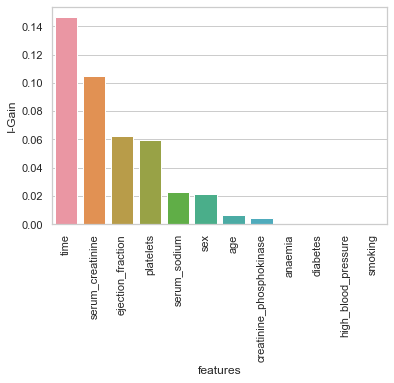

In [47]:
sns.set_theme(style="whitegrid")
normalized_df_analysis['features'] = normalized_df_analysis.index
data = normalized_df_analysis
ax = sns.barplot(x="features", y="I-Gain",data=data)
plt.xticks(rotation = 90)

## Observations

- We see first that the time feature is several magnitudes higher that all other features interms of information gain. 
- And we also notice that some features change in in gain when we normalize data.
- Since time is several maginitudes higher than all the other features in information gain. We hypothesis that we will get same results if we train model with time alone. We will see if thats the case in the end after we do forward and backward analysis

Now lets test out the data using those scaled features

In [48]:
top5_DF = df_train[unscaled_df_analysis.index[:5]]
X_top5 = top5_DF.values
gboost_top5 = cross_val_score(gboost, X_top5, y_t, cv=10)
print("10x CV Accuracy top 5 features: {0:.2f}".format(gboost_top5.mean())) 

10x CV Accuracy top 5 features: 0.76


In [49]:
top5_DF = df_train[scaled_df_analysis.index[:5]]
X_top5 = top5_DF.values
gboost_top5 = cross_val_score(gboost, X_top5, y_t, cv=10)
print("10x CV Accuracy top 5 features: {0:.2f}".format(gboost_top5.mean())) 


10x CV Accuracy top 5 features: 0.80


In [50]:
top5_DF = df_train[normalized_df_analysis.index[:5]]
X_top5 = top5_DF.values
gboost_top5 = cross_val_score(gboost, X_top5, y_t, cv=10)
print("10x CV Accuracy top 5 features: {0:.2f}".format(gboost_top5.mean())) 

10x CV Accuracy top 5 features: 0.79


## Observation
We see that normalized features gives best result so we will proceed with that
Next we run formaward and backward feature selection and see if time is indeed the only required feature. If our intersection gives 'time' as the feature to be chosen then that confirm our hypothesis that time is the only required feature

In [51]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

columns_train = df_train.columns

In [52]:
columns_train

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time'],
      dtype='object')

In [ ]:
sfs_forward = SFS(gboost, 
                  k_features=12, 
                  forward=True, 
                  floating=False, 
                  verbose=1,
                  scoring='accuracy',
                  cv=10)

sfs_forward = sfs_forward.fit(preprocessing.normalize(X_t), y_t, 
                              custom_feature_names=columns_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    5.8s finished
Features: 1/12[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    6.1s finished
Features: 2/12[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.4s finished
Features: 3/12[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    5.4s finished
Features: 4/12[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.8s finished
Features: 5/12[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

fig1 = plot_sfs(sfs_forward.get_metric_dict(), 
                ylabel='Accuracy',
                kind='std_dev')

plt.ylim([0.5, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()
print(sfs_forward.k_feature_names_)

### Observation
We see that the accurate increases only for first 4 features this is inline to the information gain analysis we did earlier. However we are not able to see a good elbow in our graph so we will do a backward analysis as well

In [ ]:
sfs_backward = SFS(gboost, 
                  k_features=1, 
                  forward=False, 
                  floating=False, 
                  verbose=1,
                  scoring='accuracy',
                  cv=10)

sfs_backward = sfs_backward.fit(preprocessing.normalize(X_t), y_t,
                              custom_feature_names=columns_train)

In [ ]:

fig1 = plot_sfs(sfs_backward.get_metric_dict(), 
                ylabel='Accuracy',
                kind='std_dev')

plt.ylim([0.5, 1])
plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()
print(sfs_backward.k_feature_names_)

### Obesrvation

- Backward feature selection gives an elbow with first feature itself and this confirms that most important feature is infact time

Now we do an intersction of both feature selction methods we expect 'time' to be only feature to come from analysis

In [ ]:
b5_feat = sfs_backward.k_feature_names_
f5_feat = sfs_forward.k_feature_names_
print((set(b5_feat).intersection(set(f5_feat))))

We indeed see that time is the only required feature lets now do a training and test with time alone and see if we can match our base line observations

In [ ]:
df_test = pd.read_csv('heart-test.csv')
df_train = pd.read_csv('heart-train.csv')

y_test = df_test.pop('DEATH_EVENT').values
# Seperating to target value
X_test = df_test.age.values
y_test=y_test.astype('int')

In [ ]:
top5_DF = df_train[normalized_df_analysis.index[:1]]
X_top5 = top5_DF.values
gboost_top5 = cross_val_score(gboost, X_top5, y_t, cv=10)
print("10x CV Accuracy top 5 features: {0:.2f}".format(gboost_top5.mean())) 

Hold Out test with just time feature

In [ ]:
gboost = GradientBoostingClassifier(random_state=0)
X_test = df_test.drop([ "anaemia","serum_creatinine","age","ejection_fraction" ,"creatinine_phosphokinase", "diabetes", "high_blood_pressure", "platelets", "serum_sodium", "sex", "smoking"], axis=1)
X_t = df_train.drop([ "DEATH_EVENT","anaemia","serum_creatinine","age","ejection_fraction" ,"creatinine_phosphokinase", "diabetes", "high_blood_pressure", "platelets", "serum_sodium", "sex", "smoking"], axis=1)
y_pred = gboost.fit(X_t, y_t).predict(X_test)
print(f'Accuracy of GBoost is at:  {accuracy_score(y_pred, y_test)*100:.2f}% ')
print(classification_report(y_test, y_pred))

In [ ]:
print(f"The baseline accuracy for model was {baseline_accuracy}")
print(baseline)


## Final observation
Now we just take time as feature and do Hold-out test and we see that even on test data we get 81% accuracy which means our model only needs to train on one feature to get almost same accuracy. This shows the importance of feature selection when deciding on making a model. With the feature selection done we are able to train the model significantly faster

#### Possible Improvements
- Make more detailed EDA analysis. 
- Apply dimensionalitreduction
- Make a pipeline